XGBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        87
           1       1.00      1.00      1.00        87

    accuracy                           1.00       174
   macro avg       1.00      1.00      1.00       174
weighted avg       1.00      1.00      1.00       174

Accuracy: 1.0

Isolation Forest Classification Report:
              precision    recall  f1-score   support

          -1       0.59      0.06      0.11       434
           1       0.50      0.96      0.66       434

    accuracy                           0.51       868
   macro avg       0.55      0.51      0.39       868
weighted avg       0.55      0.51      0.39       868

Accuracy: 0.5092165898617511


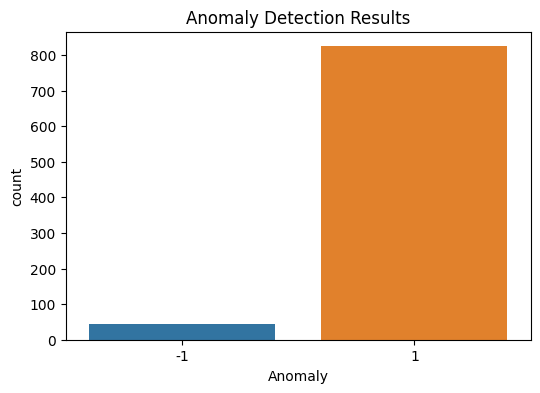

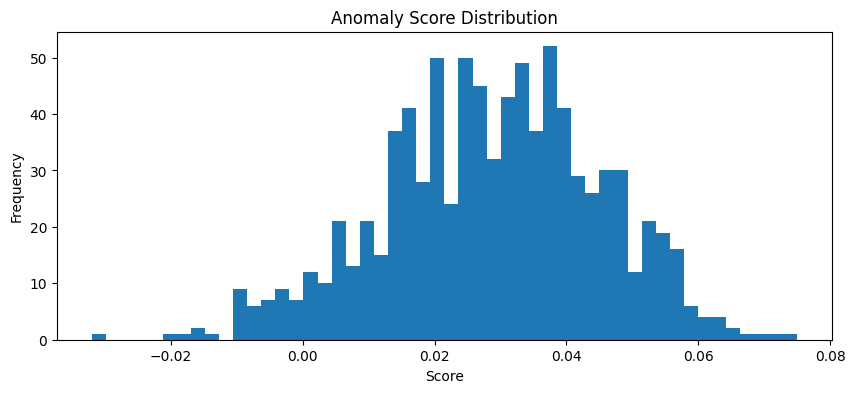

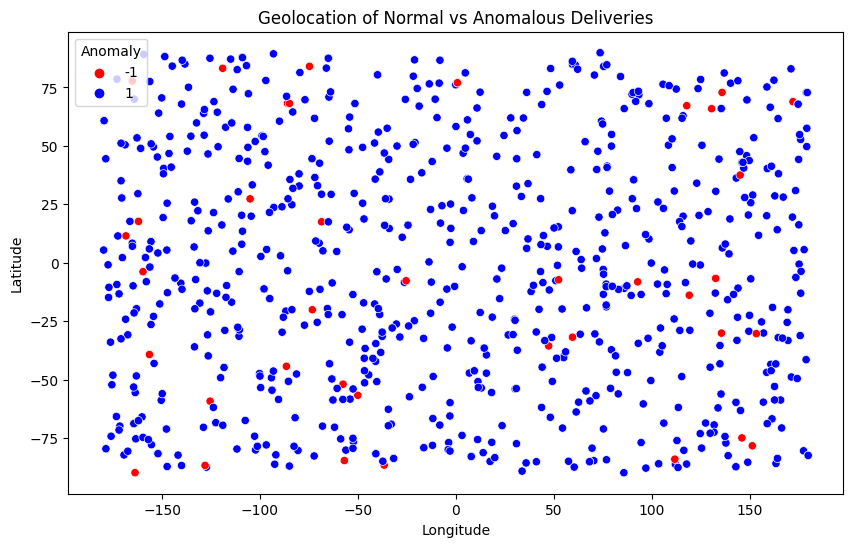

In [9]:
# Anomaly Detection and Supervised Comparison on Logistics Dataset with Synthetic Data

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.utils import resample

# Load dataset
df = pd.read_csv("/kaggle/input/smart-logistics-supply-chain-dataset/smart_logistics_dataset.csv")

# Generate synthetic minority class samples for better balance
df_majority = df[df['Logistics_Delay'] == 0]
df_minority = df[df['Logistics_Delay'] == 1]

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                  replace=True,     # sample with replacement
                                  n_samples=len(df_majority),    # to match majority class
                                  random_state=42)  # reproducible results

# Combine majority class with upsampled minority class
df = pd.concat([df_majority, df_minority_upsampled])
df = df.sample(frac=1, random_state=42).reset_index(drop=True)  # shuffle

# Feature Engineering
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Hour'] = df['Timestamp'].dt.hour
df['Weekday'] = df['Timestamp'].dt.weekday
df['Month'] = df['Timestamp'].dt.month
df['Efficiency_Ratio'] = df['Inventory_Level'] / (df['Asset_Utilization'] + 1)
df['User_Intensity'] = df['User_Transaction_Amount'] * df['User_Purchase_Frequency']
df['Weather_Severity'] = df['Temperature'] * df['Humidity']

# Select features
num_features = [
    'Latitude', 'Longitude', 'Inventory_Level', 'Temperature', 'Humidity',
    'Waiting_Time', 'User_Transaction_Amount', 'User_Purchase_Frequency',
    'Asset_Utilization', 'Demand_Forecast', 'Hour', 'Weekday', 'Month',
    'Efficiency_Ratio', 'User_Intensity', 'Weather_Severity'
]

cat_features = ['Shipment_Status', 'Traffic_Status', 'Logistics_Delay_Reason']

# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])

# Apply transformations
X = preprocessor.fit_transform(df)
y = df['Logistics_Delay']  # 1 = delayed, 0 = not delayed

# Split for supervised model
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Supervised XGBoost Classifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))

# Isolation Forest for comparison
iso_forest = IsolationForest(n_estimators=200, contamination=0.05, random_state=42)
df['Anomaly'] = iso_forest.fit_predict(X)  # -1 = anomaly, 1 = normal

# Use existing 'Logistics_Delay' as proxy label
df['True_Label'] = df['Logistics_Delay'].apply(lambda x: -1 if x == 1 else 1)

# Evaluate anomaly detection
y_true = df['True_Label']
y_pred_iso = df['Anomaly']

print("\nIsolation Forest Classification Report:")
print(classification_report(y_true, y_pred_iso))
print("Accuracy:", accuracy_score(y_true, y_pred_iso))

# Visualize anomaly counts
plt.figure(figsize=(6, 4))
sns.countplot(x='Anomaly', data=df)
plt.title('Anomaly Detection Results')
plt.show()

# Visualize anomaly scores
anomaly_scores = iso_forest.decision_function(X)
plt.figure(figsize=(10, 4))
plt.hist(anomaly_scores, bins=50)
plt.title("Anomaly Score Distribution")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.show()

# Plot anomalies by location
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Longitude', y='Latitude', hue='Anomaly', data=df, palette={1:'blue', -1:'red'})
plt.title("Geolocation of Normal vs Anomalous Deliveries")
plt.show()
